# Example of high-level interface

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
from tqdm import tqdm
from itertools import compress
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
NSAMPLES = 20000

## Toy generative model

In [3]:
def simulator(z):
    out = []
    for i in range(0, len(z), 2):
        r = ((z[i]-0.5)**2 + (z[i+1]-0.5)**2)**0.5
        mu = 1/(10*(r-0.2)**2+1e-2)
        out += [mu]
    x = np.random.poisson(out)
    return x

In [4]:
def noise(x, z):
    n = np.random.poisson(10., x.shape)
    return n + x

In [5]:
z0 = np.array([0.5, 0.7]*4)
zdim = len(z0)
x0 = noise(simulator(z0), z0)
comb1d = [[i] for i in range(zdim)]
comb2d = swyft.comb2d(range(zdim))
print(x0, z0)

[123 102 106 111] [0.5 0.7 0.5 0.7 0.5 0.7 0.5 0.7]


## Automatic inference 1-dim and 2-dim posteriors

In [6]:
ds = swyft.DataStore().init(zdim = zdim, xdim = x0.shape)
head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [7]:
re_prev = None
for r in range(1):
    td = swyft.TrainData(x0 = x0, zdim = zdim, noisehook = noise, datastore = ds, nsamples = NSAMPLES, threshold = 1e-6, parent = re_prev)
    ds.simulate(simulator)
    re = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb1d)
    re.train(max_epochs = MAX_EPOCHS, nbatch = 16, lr_schedule = [1e-3, 3e-4, 1e-4])
    re_prev = re

Constrained posterior area: 1.0
Adding 19928 new samples. Run simulator!


Simulate: 100%|██████████| 19928/19928 [00:16<00:00, 1179.86it/s]


Start training
LR iteration 0
Total epochs: 4
Validation losses: [20.80080544948578, 20.69226336479187, 20.606415450572968, 20.643492341041565]
LR iteration 1
Total epochs: 4
Validation losses: [20.46365362405777, 20.443317472934723, 20.411984264850616, 20.473051369190216]
LR iteration 2
Total epochs: 2
Validation losses: [20.301388323307037, 20.40299415588379]


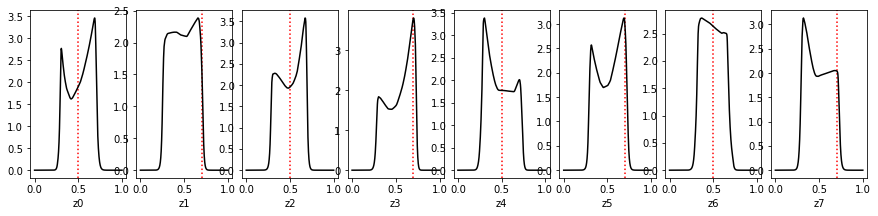

In [8]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (15, 3))

In [ ]:
re2 = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb2d)

In [11]:
re2.train(max_epochs = MAX_EPOCHS, nbatch = 16, lr_schedule = [1e-3, 3e-4, 1e-4])

Start training
LR iteration 0
Total epochs: 4
Validation losses: [67.02971386909485, 65.93203735351562, 65.73502361774445, 65.75320243835449]
LR iteration 1
Total epochs: 4
Validation losses: [65.27197825908661, 65.12346661090851, 64.60621106624603, 64.72461926937103]
LR iteration 2
Total epochs: 2
Validation losses: [64.16139614582062, 64.41378915309906]


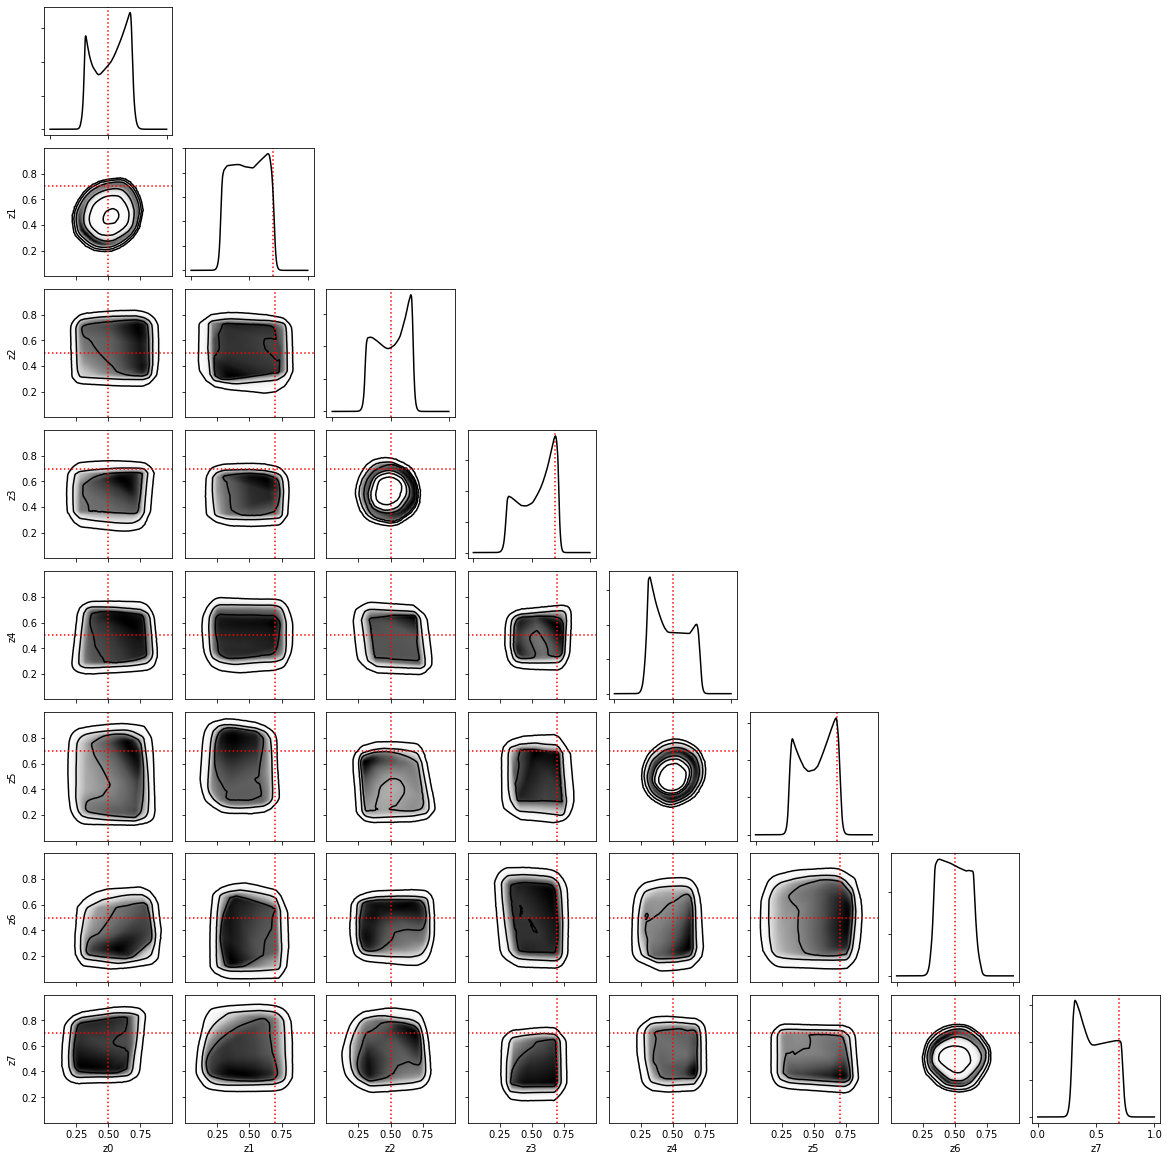

In [12]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 20)